In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from nltk.tokenize import word_tokenize
import numpy as np

def create_skip_grams(words, window_size=2):
    skip_grams = []
    for i, word in enumerate(words):
        context_words = words[max(0, i - window_size): i] + words[i + 1: i + window_size + 1]
        for context_word in context_words:
            skip_grams.append((word, context_word))
    return skip_grams

class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(Word2Vec, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.output_layer = nn.Linear(embedding_dim, vocab_size) # Σωστά ορισμένο ως output_layer
        
    def forward(self, inputs):
        embeds = self.embeddings(inputs)
        # Διόρθωση: Χρησιμοποίησε self.output_layer εδώ, όπως το όρισες στην __init__
        output = self.output_layer(embeds) 
        return output
def cosine_similarity(vec1, vec2):
    """
    Υπολογίζει την ομοιότητα συνημιτόνου μεταξύ δύο NumPy διανυσμάτων.
    """
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    
    if norm_vec1 == 0 or norm_vec2 == 0:
        return 0.0 # Αποφυγή διαίρεσης με το μηδέν
    
    return dot_product / (norm_vec1 * norm_vec2)

def get_paragraph_embedding(paragraph, model, word_to_idx_map): # Άλλαξα το όνομα παραμέτρου για σαφήνεια
    """
    Δημιουργεί ένα ενιαίο διάνυσμα (embedding) για μια παράγραφο
    κάνοντας τον μέσο όρο των embeddings των λέξεων που την απαρτίζουν.
    Χρησιμοποιεί το embedding layer από το δικό σας μοντέλο.
    """
    tokens = [word.lower() for word in word_tokenize(paragraph)]
    
    word_ids = []
    for word in tokens:
        if word in word_to_idx_map: # Χρησιμοποιούμε το word_to_idx_map
            word_ids.append(word_to_idx_map[word])
    
    if not word_ids:
        return np.zeros(model.embeddings.embedding_dim)
    
    input_tensor = torch.tensor(word_ids, dtype=torch.long).unsqueeze(0)
    
    with torch.no_grad():
        word_embeds = model.embeddings(input_tensor)
    
    paragraph_embedding = torch.mean(word_embeds, dim=1).squeeze(0)
    
    return paragraph_embedding.numpy()
    
    
    

original_text=""
pipeline1=""
pipeline2=""
pipeline3=""

try:
    with open('../text_files/text1.txt', 'r', encoding='utf-8') as file:
        original_text = file.read()
    print("File content successfully loaded into original_text.")
except FileNotFoundError:
    print("Error: The file 'text1.txt' was not found. Please make sure the file exists and the path is correct.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    
try:
    with open("../text_files/first_pipeline_text1.txt", 'r', encoding='utf-8') as file:
        pipeline1 = file.read()
    print("File content successfully loaded into pipeline1.")
except FileNotFoundError:
    print("Error: Please make sure the file exists and the path is correct.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    
try:
    with open("../text_files/second_pipeline_text1.txt", 'r', encoding='utf-8') as file:
        pipeline2 = file.read()
    print("File content successfully loaded into pipeline2.")
except FileNotFoundError:
    print("Error: Please make sure the file exists and the path is correct.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    
try:
    with open("../text_files/third_pipeline_text1.txt", 'r', encoding='utf-8') as file:
        pipeline3 = file.read()
    print("File content successfully loaded into pipeline3.")
except FileNotFoundError:
    print("Error: Please make sure the file exists and the path is correct.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    
    
chat_gpt="""Today is our Dragon Boat Festival, a special celebration in our Chinese culture. It is a time to honor and wish for safety and prosperity in our lives. I hope you also enjoy this festival, as I send you my warmest wishes.

Thank you for your message and for conveying our words to the doctor regarding his upcoming contract review. This is important for all of us.

I received this message to confirm the approval. Actually, the professor shared this with me a couple of days ago. I truly appreciate the professor’s full support for our Springer proceedings publication."""


train_data=pipeline1+pipeline2+pipeline3

words = train_data.split()

word_to_ix = {word: i for i, word in enumerate(set(words))}
ix_to_word = {i: word for i, word in enumerate(set(words))}
vocab_size = len(word_to_ix)

embedding_dim = 10 

model = Word2Vec(vocab_size, embedding_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)  

pairs = create_skip_grams(words)
n_epochs= 50 

for epoch in range(n_epochs):
    total_loss  = 0 
    for word, context in pairs:
        model.zero_grad()
        word_idx = torch.tensor([word_to_ix[word]], dtype=torch.long)
        context_idx = torch.tensor([word_to_ix[context]], dtype=torch.long)
        
        output = model(word_idx)
        loss = criterion(output, context_idx)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss}")

    #Get word vectors 
    word_vectors = {}
    for word in word_to_ix:
        word_idx = torch.tensor([word_to_ix[word]], dtype=torch.long)
        word_vectors[word] = model.embeddings(word_idx).detach().numpy()
        
print("\n--- Συγκρίσεις Παραγράφων με Word Embeddings ---")

# Υπολόγισε τα embeddings για όλες τις παραγράφους που θες να συγκρίνεις
embedding_original = get_paragraph_embedding(original_text, model, word_to_ix)
embedding_pipeline1 = get_paragraph_embedding(pipeline1, model, word_to_ix)
embedding_pipeline2 = get_paragraph_embedding(pipeline2, model, word_to_ix)
embedding_pipeline3 = get_paragraph_embedding(pipeline3, model, word_to_ix)

embedding_chat_gpt = get_paragraph_embedding(chat_gpt, model, word_to_ix)

# --- Συγκρίσεις ---
print("\n--- Original Text vs Pipelines (Word Embeddings) ---")
sim_orig_p1_we = cosine_similarity(embedding_original, embedding_pipeline1)
print(f"Original Text vs Pipeline 1: {sim_orig_p1_we:.4f}")

sim_orig_p2_we = cosine_similarity(embedding_original, embedding_pipeline2)
print(f"Original Text vs Pipeline 2: {sim_orig_p2_we:.4f}")

sim_orig_p3_we = cosine_similarity(embedding_original, embedding_pipeline3)
print(f"Original Text vs Pipeline 3: {sim_orig_p3_we:.4f}")

print("\n--- Ground Truth LLM Texts vs Pipelines (Word Embeddings) ---")



print("\nChatGPT vs Pipelines:")
sim_gpt_p1_we = cosine_similarity(embedding_chat_gpt, embedding_pipeline1)
print(f"ChatGPT vs Pipeline 1: {sim_gpt_p1_we:.4f}")
sim_gpt_p2_we = cosine_similarity(embedding_chat_gpt, embedding_pipeline2)
print(f"ChatGPT vs Pipeline 2: {sim_gpt_p2_we:.4f}")
sim_gpt_p3_we = cosine_similarity(embedding_chat_gpt, embedding_pipeline3)
print(f"ChatGPT vs Pipeline 3: {sim_gpt_p3_we:.4f}")

File content successfully loaded into original_text.
File content successfully loaded into pipeline1.
File content successfully loaded into pipeline2.
File content successfully loaded into pipeline3.
Epoch 0, Loss: 10194.179054498672
Epoch 10, Loss: 8207.42127418518
Epoch 20, Loss: 7614.628466129303
Epoch 30, Loss: 7179.276521205902
Epoch 40, Loss: 6851.7427743673325

--- Συγκρίσεις Παραγράφων με Word Embeddings ---

--- Original Text vs Pipelines (Word Embeddings) ---
Original Text vs Pipeline 1: 0.9764
Original Text vs Pipeline 2: 0.9754
Original Text vs Pipeline 3: 0.8342

--- Ground Truth LLM Texts vs Pipelines (Word Embeddings) ---

ChatGPT vs Pipelines:
ChatGPT vs Pipeline 1: 0.7632
ChatGPT vs Pipeline 2: 0.7329
ChatGPT vs Pipeline 3: 0.5860


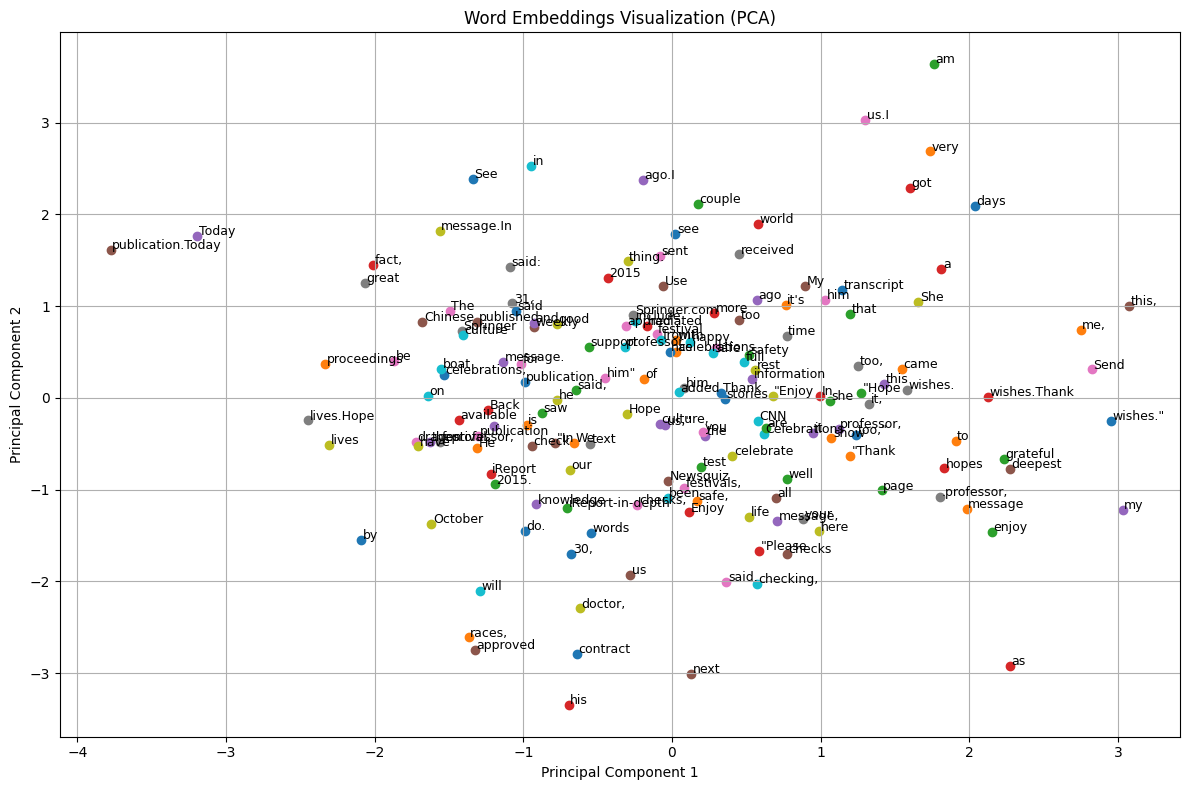

In [2]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Συγκεντρώνουμε όλα τα word embeddings σε ένα array
labels = []
vectors = []

for word, idx in word_to_ix.items():
    word_tensor = torch.tensor([idx], dtype=torch.long)
    embedding = model.embeddings(word_tensor).detach().numpy()[0]
    labels.append(word)
    vectors.append(embedding)

vectors = np.array(vectors)

# Μείωση διάστασης με PCA σε 2D
pca = PCA(n_components=2)
reduced = pca.fit_transform(vectors)

# Plot
plt.figure(figsize=(12, 8))
for i, label in enumerate(labels):
    x, y = reduced[i]
    plt.scatter(x, y)
    plt.text(x + 0.01, y + 0.01, label, fontsize=9)

plt.title("Word Embeddings Visualization (PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()
